In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from ripple_heterogeneity.utils import (
    functions,
    loading,
    batch_analysis,
    add_new_deep_sup,
)
from ripple_heterogeneity.replay import replay_run, influence_of_layer_bias_on_replay
from ripple_heterogeneity.readout import readout_explained_var
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nelpy as nel
import nelpy.plotting as npl
from matplotlib.ticker import AutoMinorLocator
from sklearn.cluster import KMeans
import os
from scipy import stats

functions.set_plotting_defaults()
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
fig_save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\figures\panels'

c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\plotting\decoding.py:9: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.


In [3]:
from ripple_heterogeneity.readout import readout_explained_var

df = pd.read_csv(r"Z:\home\ryanh\projects\ripple_heterogeneity\sessions.csv")
cell_metrics = loading.load_all_cell_metrics(df.basepath)

sessions = pd.DataFrame()
sessions["basepath"] = cell_metrics[
    cell_metrics.brainRegion.str.contains("PFC|EC1|EC2|EC3|EC4|EC5|MEC")
].basepath.unique()

In [17]:
save_path = (
    r"Z:\home\ryanh\projects\ripple_heterogeneity\readout_explained_var_ripples_extend_50ms_w_pairwise_corr_w_uid_new_deep_sup"
)

batch_analysis.run(
    sessions,
    save_path,
    readout_explained_var.run,
    parallel=True,
    overwrite=False,
    verbose=True,
    skip_if_error=False,
)
# load results
ev_df, pairwise_corr_df = readout_explained_var.load_results(save_path)

100%|██████████| 106/106 [01:04<00:00,  1.63it/s]


In [18]:
pairwise_corr_df["corrcoef"] = pairwise_corr_df["corr"] 
pairwise_corr_df = pairwise_corr_df.drop(["corr"], axis=1)


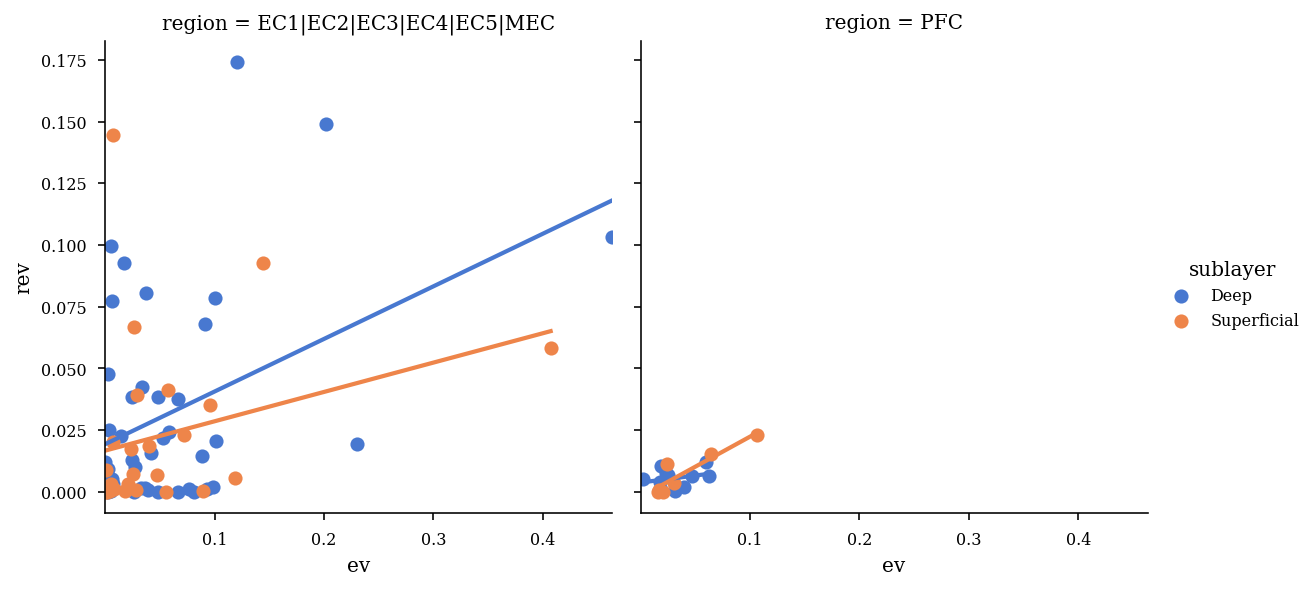

In [19]:
sns.lmplot(x="ev", y="rev", col="region", hue="sublayer", data=ev_df,
           col_wrap=2, ci=None, palette="muted", height=4,
           scatter_kws={"s": 50, "alpha": 1})

In [20]:
ev_df

,region,sublayer,ev,rev,n_ca1,n_target,basepath
0,EC1|EC2|EC3|EC4|EC5|MEC,Deep,0.007318,0.003165,16.0,10.0,Z:\Data\AYAold\AYA7\day19
1,EC1|EC2|EC3|EC4|EC5|MEC,Deep,0.048477,0.038488,21.0,44.0,Z:\Data\AYAold\AYA7\day20
2,EC1|EC2|EC3|EC4|EC5|MEC,Deep,0.093008,0.001261,21.0,68.0,Z:\Data\AYAold\AYA7\day24
3,EC1|EC2|EC3|EC4|EC5|MEC,Superficial,0.028887,0.039304,7.0,68.0,Z:\Data\AYAold\AYA7\day24
4,EC1|EC2|EC3|EC4|EC5|MEC,Deep,0.002217,0.009121,48.0,102.0,Z:\Data\AYAold\AYA9\day12
...,...,...,...,...,...,...,...
82,EC1|EC2|EC3|EC4|EC5|MEC,Deep,0.066356,0.037647,10.0,11.0,Z:\Data\Kenji\ec016.577_590
83,EC1|EC2|EC3|EC4|EC5|MEC,Superficial,0.072334,0.023140,46.0,11.0,Z:\Data\Kenji\ec016.577_590
84,EC1|EC2|EC3|EC4|EC5|MEC,Superficial,0.089017,0.000214,14.0,14.0,Z:\Data\Kenji\i01_maze01_MS.001_003
85,PFC,Deep,0.062034,0.006349,20.0,15.0,Z:\Data\ORproject\OR18\day1


In [21]:
df_long = pd.DataFrame()
df_long["ev"] = np.hstack([ev_df.ev.values, ev_df.rev.values])
df_long["ev_labels"] = np.hstack([["ev"]*ev_df.ev.shape[0], ["rev"]*ev_df.rev.shape[0]])
df_long["region"] = np.hstack([ev_df.region.values, ev_df.region.values])
df_long["sublayer"] = np.hstack([ev_df.sublayer.values, ev_df.sublayer.values])
df_long["n_ca1"] = np.hstack([ev_df.n_ca1.values, ev_df.n_ca1.values])
df_long["n_target"] = np.hstack([ev_df.n_target.values, ev_df.n_target.values])
df_long["basepath"] = np.hstack([ev_df.basepath.values, ev_df.basepath.values])


df_long

,ev,ev_labels,region,sublayer,n_ca1,n_target,basepath
0,0.007318,ev,EC1|EC2|EC3|EC4|EC5|MEC,Deep,16.0,10.0,Z:\Data\AYAold\AYA7\day19
1,0.048477,ev,EC1|EC2|EC3|EC4|EC5|MEC,Deep,21.0,44.0,Z:\Data\AYAold\AYA7\day20
2,0.093008,ev,EC1|EC2|EC3|EC4|EC5|MEC,Deep,21.0,68.0,Z:\Data\AYAold\AYA7\day24
3,0.028887,ev,EC1|EC2|EC3|EC4|EC5|MEC,Superficial,7.0,68.0,Z:\Data\AYAold\AYA7\day24
4,0.002217,ev,EC1|EC2|EC3|EC4|EC5|MEC,Deep,48.0,102.0,Z:\Data\AYAold\AYA9\day12
...,...,...,...,...,...,...,...
169,0.037647,rev,EC1|EC2|EC3|EC4|EC5|MEC,Deep,10.0,11.0,Z:\Data\Kenji\ec016.577_590
170,0.023140,rev,EC1|EC2|EC3|EC4|EC5|MEC,Superficial,46.0,11.0,Z:\Data\Kenji\ec016.577_590
171,0.000214,rev,EC1|EC2|EC3|EC4|EC5|MEC,Superficial,14.0,14.0,Z:\Data\Kenji\i01_maze01_MS.001_003
172,0.006349,rev,PFC,Deep,20.0,15.0,Z:\Data\ORproject\OR18\day1


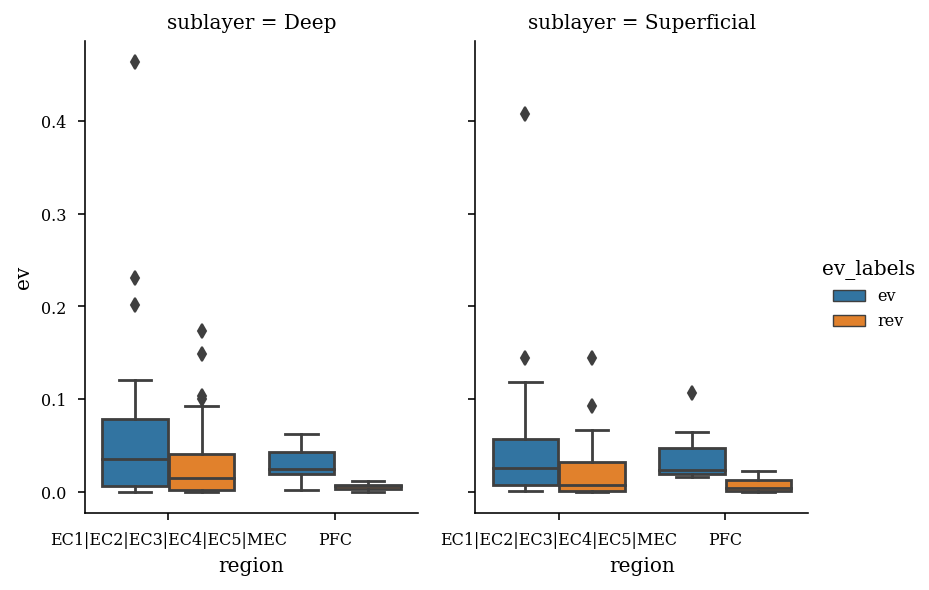

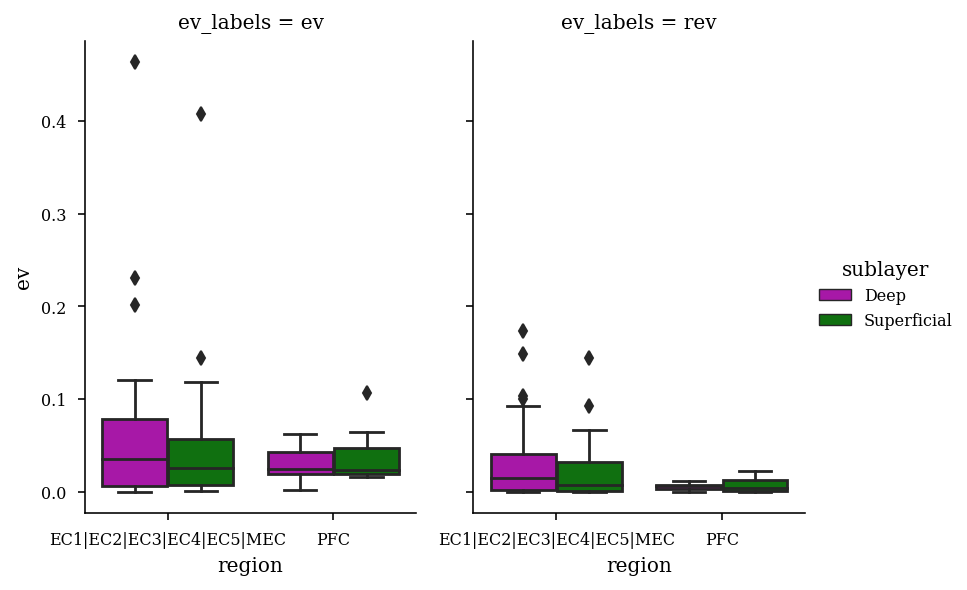

In [22]:
g = sns.catplot(x="region", y="ev",
                hue="ev_labels", col="sublayer",
                data=df_long, kind="box",
                height=4, aspect=.7)
sns.despine()
plt.show()

g = sns.catplot(x="region", y="ev",
                hue="sublayer", col="ev_labels",
                data=df_long, kind="box",palette=["m", "g"],
                height=4, aspect=.7)

# g = sns.catplot(x="region", y="ev",
#                 hue="sublayer", col="ev_labels",
#                 data=df_long,palette=["m", "g"],
#                 height=4, aspect=.7)
sns.despine()
plt.show()

In [23]:
ev_df.basepath.value_counts(), ev_df.region.value_counts() 

ev_df["ev_norm"] = ev_df.ev - ev_df.rev

In [24]:
df_wide = pd.pivot(
    ev_df, index=["region","basepath"], columns="sublayer", values=["ev","rev"]
).reset_index()
df_wide
df_wide["deep_ev_norm"] = df_wide["ev"]["Deep"] - df_wide["rev"]["Deep"]
df_wide["sup_ev_norm"] = df_wide["ev"]["Superficial"] - df_wide["rev"]["Superficial"]
df_wide
# ratio between deep and sup normed ev (offset by 1 for ratio)
df_wide["deep_sup_ev_ratio_ev_norm"] = ((df_wide["deep_ev_norm"]+1) - (df_wide["sup_ev_norm"]+1)) / ((df_wide["deep_ev_norm"]+1) + (df_wide["sup_ev_norm"]+1))

df_wide["deep_sup_ev_ratio"] = (df_wide["ev"]["Deep"] - df_wide["ev"]["Superficial"]) / (df_wide["ev"]["Deep"] + df_wide["ev"]["Superficial"])

df_wide["constant"] = 1
df_wide.head(10)

region                   basepath        ev  \
sublayer                                                          Deep   
0         EC1|EC2|EC3|EC4|EC5|MEC  Z:\Data\AYAold\AYA7\day19  0.007318   
1         EC1|EC2|EC3|EC4|EC5|MEC  Z:\Data\AYAold\AYA7\day20  0.048477   
2         EC1|EC2|EC3|EC4|EC5|MEC  Z:\Data\AYAold\AYA7\day24  0.093008   
3         EC1|EC2|EC3|EC4|EC5|MEC  Z:\Data\AYAold\AYA9\day12  0.002217   
4         EC1|EC2|EC3|EC4|EC5|MEC  Z:\Data\AYAold\AYA9\day14  0.000014   
5         EC1|EC2|EC3|EC4|EC5|MEC  Z:\Data\AYAold\AYA9\day15  0.076570   
6         EC1|EC2|EC3|EC4|EC5|MEC  Z:\Data\AYAold\AYA9\day16  0.036018   
7         EC1|EC2|EC3|EC4|EC5|MEC  Z:\Data\AYAold\AYA9\day17  0.048640   
8         EC1|EC2|EC3|EC4|EC5|MEC         Z:\Data\HMC1\day10  0.038766   
9         EC1|EC2|EC3|EC4|EC5|MEC         Z:\Data\HMC1\day12  0.005146   

                           rev             deep_ev_norm sup_ev_norm  \
sublayer Superficial      Deep Superficial                            
0                NaN  0.003165         NaN     0.004153         NaN   
1                NaN  0.038488         NaN     0.009989         NaN   
2           0.028887  0.001261    0.039304     0.091747   -0.010417   
3           0.000734  0.009121    0.008785    -0.006905   -0.008052   
4           0.000680  0.007983    0.000069    -0.007969    0.000610   
5           0.019099  0.001160    0.000708     0.075410    0.018391   
6           0.026131  0.001714    0.066716     0.034304   -0.040585   
7           0.040043  0.000026    0.018502     0.048614    0.021541   
8           0.047480  0.000781    0.006825     0.037985    0.040655   
9           0.007753  0.000236    0.001013     0.004909    0.006740   

         deep_sup_ev_ratio_ev_norm deep_sup_ev_ratio constant  
sublayer                                                       
0                              NaN               NaN        1  
1                              NaN               NaN        1  
2                         0.049086          0.526034        1  
3                         0.000578          0.502668        1  
4                        -0.004305         -0.959767        1  
5                         0.027232          0.600730        1  
6                         0.037562          0.159097        1  
7                         0.013078          0.096941        1  
8                        -0.001285         -0.101032        1  
9                        -0.000910         -0.202147        1

In [25]:
from scipy import stats
x = df_wide[df_wide.region == "EC1|EC2|EC3|EC4|EC5|MEC"].deep_sup_ev_ratio_ev_norm
x = x[~np.isnan(x)]
print(stats.ttest_1samp(x, 0,alternative="two-sided"))

x = df_wide[df_wide.region == "PFC"].deep_sup_ev_ratio_ev_norm
x = x[~np.isnan(x)]
print(stats.ttest_1samp(x, 0,alternative="two-sided"))

x = df_wide[df_wide.region == "EC1|EC2|EC3|EC4|EC5|MEC"].deep_sup_ev_ratio
x = x[~np.isnan(x)]
print(stats.ttest_1samp(x, 0,alternative="two-sided"))

x = df_wide[df_wide.region == "PFC"].deep_sup_ev_ratio
x = x[~np.isnan(x)]
print(stats.ttest_1samp(x, 0,alternative="two-sided"))

Ttest_1sampResult(statistic=1.2965976976438702, pvalue=0.20883696119889095)
Ttest_1sampResult(statistic=-1.2257539339355532, pvalue=0.26621618809172193)
Ttest_1sampResult(statistic=0.0023985138179451453, pvalue=0.9981089037809732)
Ttest_1sampResult(statistic=-1.2061914004500176, pvalue=0.2731427262899859)


In [26]:
import statsmodels.formula.api as smf
results = smf.ols('deep_sup_ev_ratio_ev_norm ~ region', data=df_wide).fit()
print(results.summary())



                                OLS Regression Results                               
Dep. Variable:     deep_sup_ev_ratio_ev_norm   R-squared:                       0.052
Model:                                   OLS   Adj. R-squared:                  0.017
Method:                        Least Squares   F-statistic:                     1.479
Date:                       Mon, 13 Jun 2022   Prob (F-statistic):              0.234
Time:                               13:43:18   Log-Likelihood:                 73.973
No. Observations:                         29   AIC:                            -143.9
Df Residuals:                             27   BIC:                            -141.2
Df Model:                                  1                                         
Covariance Type:                   nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------

In [27]:
results = smf.ols('deep_sup_ev_ratio ~ region', data=df_wide).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:      deep_sup_ev_ratio   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                 -0.016
Method:                 Least Squares   F-statistic:                    0.5624
Date:                Mon, 13 Jun 2022   Prob (F-statistic):              0.460
Time:                        13:43:22   Log-Likelihood:                -18.873
No. Observations:                  29   AIC:                             41.75
Df Residuals:                      27   BIC:                             44.48
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.0003      0.102      0.003

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

EC1|EC2|EC3|EC4|EC5|MEC v.s. PFC: t-test independent samples with Bonferroni correction, P_val=2.344e-01 stat=1.216e+00


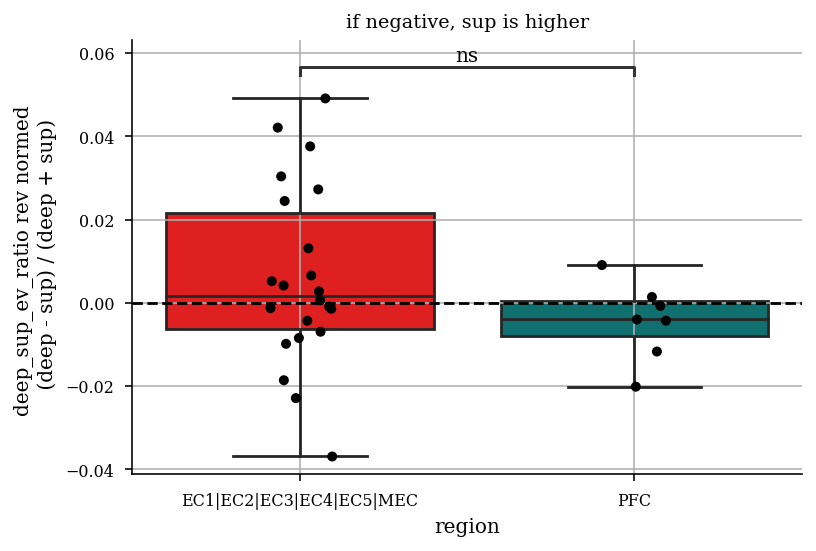

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

EC1|EC2|EC3|EC4|EC5|MEC v.s. PFC: t-test independent samples with Bonferroni correction, P_val=4.598e-01 stat=7.500e-01


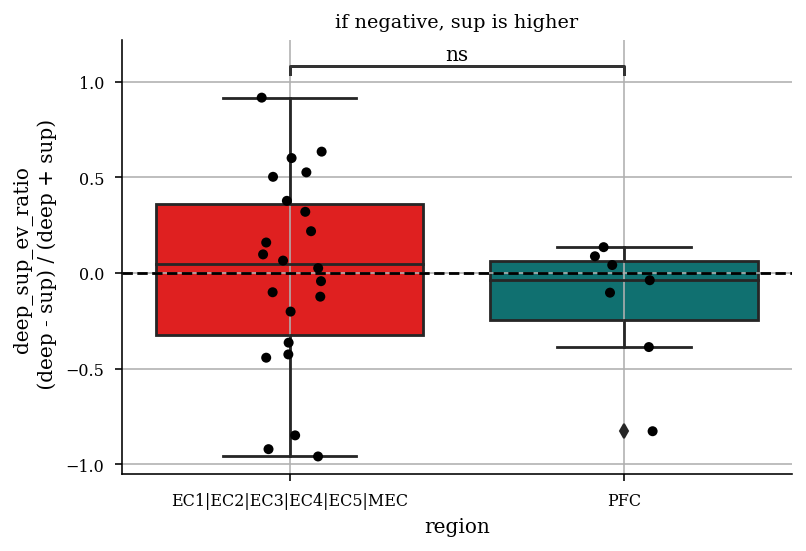

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

PFC_Deep v.s. PFC_Superficial: t-test independent samples with Bonferroni correction, P_val=1.000e+00 stat=-6.205e-01
EC1|EC2|EC3|EC4|EC5|MEC_Deep v.s. EC1|EC2|EC3|EC4|EC5|MEC_Superficial: t-test independent samples with Bonferroni correction, P_val=1.000e+00 stat=-1.483e-01


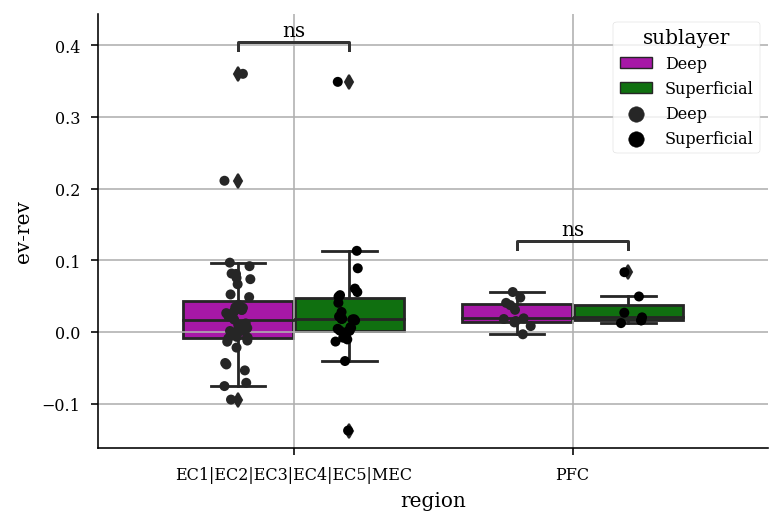

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

PFC_Deep v.s. PFC_Superficial: t-test independent samples with Bonferroni correction, P_val=9.918e-01 stat=-6.968e-01
EC1|EC2|EC3|EC4|EC5|MEC_Deep v.s. EC1|EC2|EC3|EC4|EC5|MEC_Superficial: t-test independent samples with Bonferroni correction, P_val=1.000e+00 stat=2.964e-01


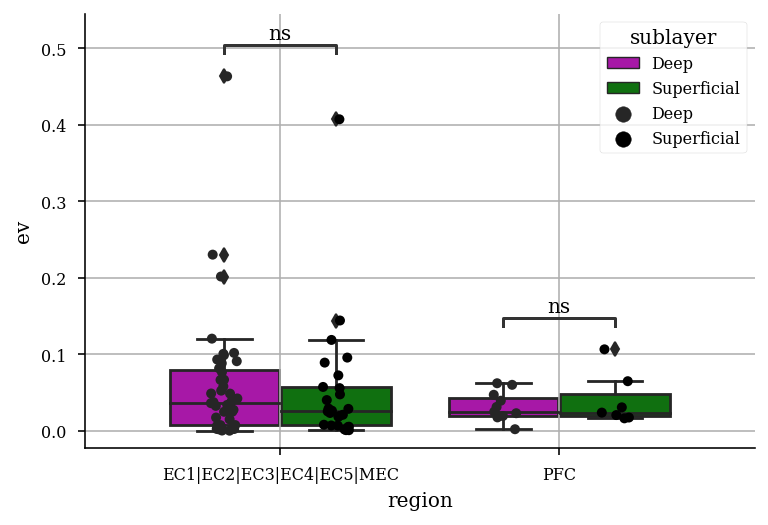

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

PFC_Deep v.s. PFC_Superficial: t-test independent samples with Bonferroni correction, P_val=9.630e-01 stat=-7.207e-01
EC1|EC2|EC3|EC4|EC5|MEC_Deep v.s. EC1|EC2|EC3|EC4|EC5|MEC_Superficial: t-test independent samples with Bonferroni correction, P_val=7.435e-01 stat=8.993e-01


(<AxesSubplot:xlabel='region', ylabel='rev'>,
  <statannot.StatResult.StatResult at 0x220d786f9a0>])

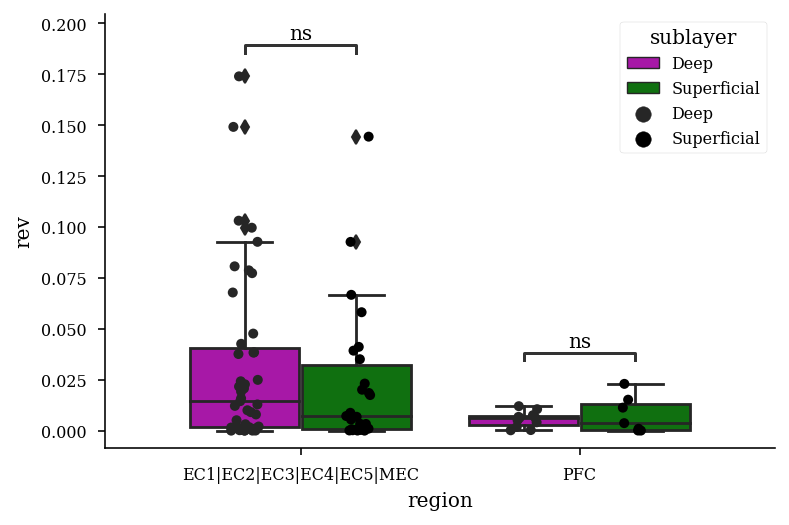

In [28]:
from statannot import add_stat_annotation

sns.boxplot(y="deep_sup_ev_ratio_ev_norm", x="region",
            palette=["r", "teal"],
            data=df_wide)
sns.stripplot(y="deep_sup_ev_ratio_ev_norm", x="region",
            data=df_wide,dodge=True,color='k')
sns.despine()
plt.ylabel("deep_sup_ev_ratio rev normed \n (deep - sup) / (deep + sup)")
plt.axhline(0, color='k', linestyle='--')
plt.grid()
plt.title("if negative, sup is higher")
add_stat_annotation(plt.gca(), data=df_wide, y="deep_sup_ev_ratio_ev_norm", x="region",order=["EC1|EC2|EC3|EC4|EC5|MEC", "PFC"],
                    box_pairs=[("EC1|EC2|EC3|EC4|EC5|MEC", "PFC")],
                    test='t-test_ind', text_format='star', loc='inside', verbose=2)
plt.show()

sns.boxplot(y="deep_sup_ev_ratio", x="region",
            palette=["r", "teal"],
            data=df_wide)
sns.stripplot(y="deep_sup_ev_ratio", x="region",color='k',
            data=df_wide,dodge=True)
sns.despine()
plt.ylabel("deep_sup_ev_ratio \n (deep - sup) / (deep + sup)")
plt.axhline(0, color='k', linestyle='--')
plt.grid()
plt.title("if negative, sup is higher")
add_stat_annotation(plt.gca(), data=df_wide, y="deep_sup_ev_ratio", x="region",order=["EC1|EC2|EC3|EC4|EC5|MEC", "PFC"],
                    box_pairs=[("EC1|EC2|EC3|EC4|EC5|MEC", "PFC")],
                    test='t-test_ind', text_format='star', loc='inside', verbose=2)
plt.show()


sns.boxplot(y="ev_norm", x="region",
            hue="sublayer", palette=["m", "g"],
            data=ev_df)
sns.stripplot(y="ev_norm", x="region",
            hue="sublayer",data=ev_df,dodge=True,color='k')
sns.despine()
plt.ylabel('ev-rev')
plt.grid()
box_pairs=[(("EC1|EC2|EC3|EC4|EC5|MEC", "Deep"), ("EC1|EC2|EC3|EC4|EC5|MEC", "Superficial")),
                (("PFC", "Deep"), ("PFC", "Superficial")),
            ]
add_stat_annotation(plt.gca(), data=ev_df, y="ev_norm", x="region",hue="sublayer",
                    box_pairs=box_pairs,
                    test='t-test_ind', text_format='star', loc='inside', verbose=2)
plt.show()

sns.boxplot(y="ev", x="region",
            hue="sublayer", palette=["m", "g"],
            data=ev_df)

sns.stripplot(y="ev", x="region",
            hue="sublayer",data=ev_df,dodge=True,color='k')
sns.despine()
plt.grid()
add_stat_annotation(plt.gca(), data=ev_df, y="ev", x="region",hue="sublayer",
                    box_pairs=box_pairs,
                    test='t-test_ind', text_format='star', loc='inside', verbose=2)
plt.show()

sns.boxplot(y="rev", x="region",
            hue="sublayer", palette=["m", "g"],
            data=ev_df)
sns.stripplot(y="rev", x="region",
            hue="sublayer",data=ev_df,dodge=True,color='k')
sns.despine()
add_stat_annotation(plt.gca(), data=ev_df, y="rev", x="region",hue="sublayer",
                    box_pairs=box_pairs,
                    test='t-test_ind', text_format='star', loc='inside', verbose=2)

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

MEC v.s. PFC: t-test independent samples with Bonferroni correction, P_val=2.344e-01 stat=1.216e+00


Text(0.5, -1.3910415638018083, '')

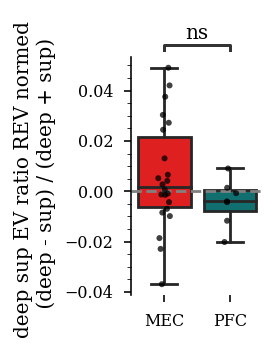

In [29]:
fig = plt.figure(
    figsize=functions.set_size("thesis", fraction=0.2, subplots=(3, 1)), edgecolor=None
)

group_colors = {"MEC": "#de2020", "PFC": "#116f70"}
sns.set_palette(sns.color_palette(group_colors.values()))

df_wide.loc[df_wide.region == "EC1|EC2|EC3|EC4|EC5|MEC", "region"] = "MEC"

ax = sns.boxplot(y="deep_sup_ev_ratio_ev_norm", x="region",
            palette=["#de2020", "#116f70"],
            data=df_wide,showfliers=False,saturation=1)
sns.stripplot(y="deep_sup_ev_ratio_ev_norm", x="region",
            data=df_wide,dodge=True,color='k',size=3,alpha=.75)


sns.despine(bottom=True)
ax = plt.gca()
ax.yaxis.set_minor_locator(AutoMinorLocator())
plt.ylabel("deep sup EV ratio REV normed \n (deep - sup) / (deep + sup)")
plt.axhline(0, color='grey', linestyle='--')
add_stat_annotation(plt.gca(), data=df_wide, y="deep_sup_ev_ratio_ev_norm", x="region",order=["MEC", "PFC"],
                    box_pairs=[("MEC", "PFC")],
                    test='t-test_ind', text_format='star', loc='outside', verbose=2)
plt.xlabel("")

# plt.savefig(
#     os.path.join(fig_save_path, "explained_var_deep_sup_ratio_regions.svg"),
#     dpi=300,
#     bbox_inches="tight",
# )

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

PFC_Deep v.s. PFC_Superficial: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=3.400e+01
MEC_Deep v.s. MEC_Superficial: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=5.420e+02


(<AxesSubplot:xlabel='region', ylabel='$EV-REV$'>,
  <statannot.StatResult.StatResult at 0x220d791b670>])

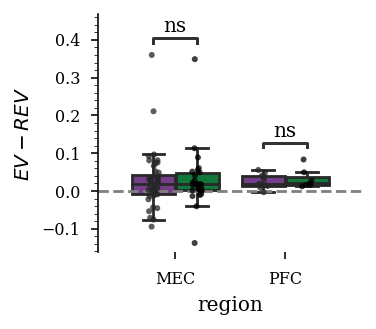

In [30]:
w,h = functions.set_size("thesis", fraction=0.2, subplots=(3, 1))

fig = plt.figure(
    figsize=(w*2,h), edgecolor=None
)

group_colors = {"Deep": "#7b3294", "Superficial": "#008837"}
sns.set_palette(sns.color_palette(group_colors.values()))

ev_df.loc[ev_df.region == "EC1|EC2|EC3|EC4|EC5|MEC", "region"] = "MEC"

sns.boxplot(y="ev_norm", x="region",
            hue="sublayer", hue_order=group_colors.keys(),
            data=ev_df,showfliers=False)
sns.stripplot(y="ev_norm", x="region",
            hue="sublayer",data=ev_df,dodge=True,color='k',size=3,alpha=.75)
sns.despine(bottom=True)
ax = plt.gca()
ax.yaxis.set_minor_locator(AutoMinorLocator())
plt.ylabel('$EV-REV$')
# plt.grid()
plt.axhline(0, color='grey', linestyle='--')
plt.legend("",
    frameon=False,
)
box_pairs=[(("MEC", "Deep"), ("MEC", "Superficial")),
                (("PFC", "Deep"), ("PFC", "Superficial")),
            ]
add_stat_annotation(plt.gca(), data=ev_df, y="ev_norm", x="region",hue="sublayer",
                    box_pairs=box_pairs,
                    test='Mann-Whitney', text_format='star', loc='inside', verbose=2)
# plt.savefig(
#     os.path.join(fig_save_path, "explained_var_deep_sup_regions.svg"),
#     dpi=300,
#     bbox_inches="tight",
# )